In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# load necessary libraries above ^

# reading the csv files
df_kaggle = pd.read_csv('Student_performance_data.csv')
df_enrich = pd.read_csv('enrichment_data.csv')

# merging two datasets based on student id
# keeping only matching ids with 'inner' join
df_final = pd.merge(df_kaggle, df_enrich, on='StudentID', how='inner')

# checking if merge worked correctly
print("New data shape: " + str(df_final.shape))
print("\n--- head of merged data ---")

# just checking specific columns to be sure
cols_to_check = ['StudentID', 'GPA', 'SleepDuration', 'DailyStudyHours', 'StressLevel']
print(df_final[cols_to_check].head())

# correlation matrix
# selecting cols that might affect GPA
cols_of_interest = [
    'GPA', 'SleepDuration', 'DailyStudyHours', 
    'StressLevel', 'MotivationLevel', 'SocialMediaUsage', 'Absences'
]

corr_matrix = df_final[cols_of_interest].corr()

print("\n--- Correlation with GPA ---")
print(corr_matrix['GPA'].sort_values(ascending=False))

# --- hypothesis testing part ---

# hyp 1: sleep duration vs GPA
# checking pearson correlation
corr_sleep, p_sleep = stats.pearsonr(df_final['SleepDuration'], df_final['GPA'])

print("\n--- Hypothesis 1: Sleep vs GPA ---")
print("Correlation (r): %.4f" % corr_sleep)
print("P-value: %.4f" % p_sleep)

# p-value check
if p_sleep < 0.05:
    print("Result: Significant relationship found.")
else:
    print("Result: No significant relationship.")

# hyp 2: does stress affect grades?
# split into low stress (1-3) and high stress (4-5)
low_stress_group = df_final[df_final['StressLevel'] <= 3]['GPA']
high_stress_group = df_final[df_final['StressLevel'] > 3]['GPA']

# t-test to compare means
t_stat, p_val_stress = stats.ttest_ind(low_stress_group, high_stress_group, equal_var=False)

print("\n--- Hypothesis 2: Stress vs GPA ---")
print("Avg GPA (Low Stress): %.4f" % low_stress_group.mean())
print("Avg GPA (High Stress): %.4f" % high_stress_group.mean())
print("T-Stat: %.4f, P-value: %.4f" % (t_stat, p_val_stress))

if p_val_stress < 0.05:
    print("Result: Significant difference between groups.")
else:
    print("Result: No significant difference.")

New data shape: (20, 20)

--- head of merged data ---
   StudentID       GPA  SleepDuration  DailyStudyHours  StressLevel
0       1001  2.929196            7.5              2.0            2
1       1002  3.042915            6.0              1.0            4
2       1003  0.112602            8.0              3.0            1
3       1004  2.054218            5.5              0.5            5
4       1005  1.288061            7.0              2.5            3

--- Correlation with GPA ---
GPA                 1.000000
SocialMediaUsage    0.139341
StressLevel         0.131551
SleepDuration      -0.059648
MotivationLevel    -0.129222
DailyStudyHours    -0.154371
Absences           -0.937815
Name: GPA, dtype: float64

--- Hypothesis 1: Sleep vs GPA ---
Correlation (r): -0.0596
P-value: 0.8027
Result: No significant relationship.

--- Hypothesis 2: Stress vs GPA ---
Avg GPA (Low Stress): 2.0049
Avg GPA (High Stress): 2.0430
T-Stat: -0.0737, P-value: 0.9436
Result: No significant difference.


Data re-loaded. Shape: (20, 20)

--- Model 1: Linear Regression Results ---
R2 Score: 0.8684

Feature Impact (Coefficients):
            Feature  Coefficient
2     SleepDuration     0.356357
4       StressLevel     0.061943
1   StudyTimeWeekly     0.044716
0          Absences    -0.097615
6  SocialMediaUsage    -0.187302
3   DailyStudyHours    -0.231596
5   MotivationLevel    -0.340503

--- Model 2: Random Forest Results ---
Accuracy: 0.5000

Confusion Matrix (Errors):
[[0 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 2]]


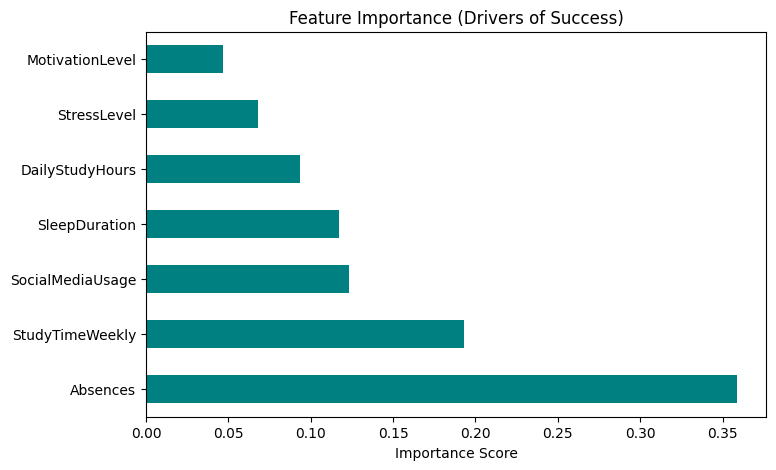

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

# --- step 1: reload the data (needed because we restarted kernel) ---

# reading files again
df_kaggle = pd.read_csv('Student_performance_data.csv')
df_enrich = pd.read_csv('enrichment_data.csv')

# merging to recreate df_final
df_final = pd.merge(df_kaggle, df_enrich, on='StudentID', how='inner')
print("Data re-loaded. Shape: " + str(df_final.shape))

# --- step 2: machine learning setup ---

# defining features (X) and target (y)
# mixing kaggle data with my collected data
features = ['Absences', 'StudyTimeWeekly', 'SleepDuration', 'DailyStudyHours', 'StressLevel', 'MotivationLevel', 'SocialMediaUsage']

X = df_final[features]
y_gpa = df_final['GPA']          # target for regression (exact number)
y_class = df_final['GradeClass'] # target for classification (grade letter)

# splitting into training (80%) and testing (20%)
# random_state fixed to get consistent results
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_gpa, test_size=0.2, random_state=42)
# separate split for classification target
_, _, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42)

# --- model 1: linear regression (predicting GPA) ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_reg)
y_pred_reg = lin_reg.predict(X_test)

print("\n--- Model 1: Linear Regression Results ---")
# r2 score: close to 1 is good, close to 0 is bad
print("R2 Score: %.4f" % r2_score(y_test_reg, y_pred_reg))

# checking which feature has the biggest impact
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lin_reg.coef_})
print("\nFeature Impact (Coefficients):")
print(coef_df.sort_values(by='Coefficient', ascending=False))

# --- model 2: random forest (predicting grade class) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_cls)
y_pred_cls = rf_model.predict(X_test)

print("\n--- Model 2: Random Forest Results ---")
print("Accuracy: %.4f" % accuracy_score(y_test_cls, y_pred_cls))

print("\nConfusion Matrix (Errors):")
print(confusion_matrix(y_test_cls, y_pred_cls))

# visualization: what actually matters?
importances = pd.Series(rf_model.feature_importances_, index=X.columns)

plt.figure(figsize=(8, 5))
importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Feature Importance (Drivers of Success)')
plt.xlabel('Importance Score')
plt.show()